In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import statistics
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.lib.stride_tricks import as_strided

In [33]:
data = pd.read_csv("./pison_data_interview.csv", header=None, names=["timestamp","chan0_raw","chan1_raw","chan0_hp","chan1_hp","quat_x","quat_y","quat_z","quat_w","gyro_x","gyro_y","gyro_z","acc_x","acc_y","acc_z","label","rep"])
eng_data = data[["timestamp","chan0_hp","chan1_hp","label"]]

In [34]:
eng_data.head()

,timestamp,chan0_hp,chan1_hp,label
0,1514824.503,-11889,17295,0
1,1514827.496,-2063,13384,0
2,1514830.493,2757,16008,0
3,1514833.500,7504,5644,0
4,1514836.498,-3855,-15893,0


In [35]:
# find timestamp breaks to identify trial starts
trial_idx = eng_data[(np.abs(eng_data.label.diff())>0)].index.tolist()
trial_timestamp = eng_data.iloc[trial_idx].timestamp

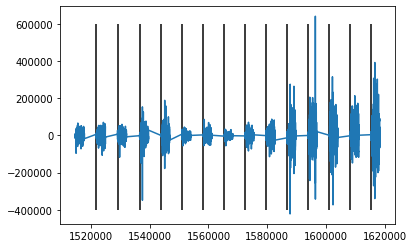

In [36]:
plt.plot(eng_data.timestamp, eng_data.chan0_hp)
plt.vlines(trial_timestamp, ymin=-400000, ymax=600000);

In [37]:
def windowed_view(arr, window, overlap):
    arr = np.asarray(arr)
    window_step = window - overlap
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap) // window_step,
                                  window)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) +
                   arr.strides[-1:])
    return as_strided(arr, shape=new_shape, strides=new_strides)

In [38]:
chan0_all_windows = []
chan1_all_windows = []

for trial_num in range(len(trial_idx)-1):
    chan0_windows = windowed_view(eng_data.iloc[trial_idx[trial_num]:trial_idx[trial_num+1]].chan0_hp,60,20)
    chan1_windows = windowed_view(eng_data.iloc[trial_idx[trial_num]:trial_idx[trial_num+1]].chan1_hp,60,20)
    chan0_all_windows.append(chan0_windows.tolist())
    chan1_all_windows.append(chan1_windows.tolist())
    

In [39]:
chan0_all_windows = [item for sublist in chan0_all_windows for item in sublist]
chan1_all_windows = [item for sublist in chan1_all_windows for item in sublist]

In [40]:
chan0_integrals = scipy.integrate.simps(chan0_all_windows)
chan1_integrals = scipy.integrate.simps(chan0_all_windows)

chan0_ln_variance = [statistics.variance(x) for x in chan0_all_windows]
chan1_ln_variance = [statistics.variance(x) for x in chan1_all_windows]

chan0_mean = [np.abs(np.mean(x)) for x in chan0_all_windows]
chan1_mean = [np.abs(np.mean(x)) for x in chan1_all_windows]

In [41]:
eng_features = pd.DataFrame({"chan0_integrals": chan0_integrals, "chan1_integrals": chan1_integrals, "chan0_ln_variance": chan0_ln_variance, "chan1_ln_variance": chan1_ln_variance, "chan0_mean": chan0_mean, "chan1_mean": chan1_mean})
                  

In [42]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
eng_scaled = ss.fit_transform(eng_features)

In [43]:
# Instantiate PCA.
pca = PCA(random_state = 42)

# Fit PCA on the training data.
pca.fit(eng_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

# Transform PCA on the training data.
eng_pca = pca.transform(eng_scaled)

In [44]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance: {np.round(var_exp,3)}')

Explained variance: [0.401 0.342 0.123 0.089 0.046 0.   ]


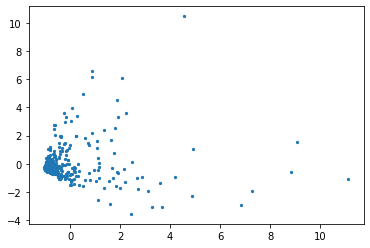

In [45]:
plt.scatter(eng_pca[:,0],eng_pca[:,1], s=5);